Demonstration of how to make the usage of ``phantasy`` Python package on accelerator machine tunning, here the *accelertor* used here is provided by one of the tools that included in ``phantasy``. ``phantasy`` itself is just a word selcted alphabets from "Physics High-level Applications and Toolkits for Accelerator System". 

Main features of ``phantasy``:
1. Modeling and tuning accelerator on high-level computing stage;
2. General interface for physics applications;

Facts should be informed before issuing the following interactive operations:
1. Start machine, here machine is just a virtual accelerator relying on certain modeling code, e.g. FLAME is used, the following command could be invoked to start it: ``phytool flame-vastart --mach='FRIB_FLAME'``, which is provided by ``phantasy`` as a convenient toolkit.
2. Install ``phantasy`` python package, by ``pip install <phantasy package>`` or ``git clone <phantasy repo address>``, and ``PYTHONPATH`` may need to be setup.
3. Python 2.7.x is required, since ``phantasy`` is developed and tested in Python 2.7.12, however, there is also future plans to let it support Python 3.x.
4. Linux OS is recommanded, though Python is somewhat cross-platform software solution, more testing needs to be done to see how much do we need to adjust to let ``phantasy`` truely become a cross-platform creature.
5. Required web services: Channel Finder Service, Scan Service.

<img src="phantasy-20170118.png" title="phantasy framework", width=800, align=left>

## Import required modules/packages

In [1]:
from __future__ import print_function
import os
import time
import numpy as np

from phantasy import MachinePortal
from phantasy import get_readback
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MachinePortal?

## Define machine configuration path

In [3]:
machine_repo = "/home/tong1/work/FRIB/projects/machines"
machine = os.path.join(machine_repo, "FRIB_FLAME")

## Initialize high-level machine according to machine configuration files

In [4]:
mp = MachinePortal(machine=machine, segment="LINAC")
lat = mp.work_lattice_conf

/home/tong1/work/FRIB/projects/machines/FRIB_FLAME LINAC


/usr/lib/python2.7/dist-packages/urllib3/connectionpool.py:794: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


## Retrive data from machine (EPICS control environment), e.g. get BPMs reading to illustrate beam trajectory

In [5]:
elem_BPM = mp.get_elements(type='BPM')

In [6]:
elem_BPM[0].pv()

[u'VA:LS1_CA01:BPM_D1129:X_RD',
 u'VA:LS1_CA01:BPM_D1129:Y_RD',
 u'VA:LS1_CA01:BPM_D1129:ENG_RD',
 u'VA:LS1_CA01:BPM_D1129:PHA_RD']

In [7]:
a= mp.get_pv_names(elem_BPM,'X')

In [8]:
a.keys()

['X']

In [9]:
pv_bpm_x = mp.get_pv_names(elem_BPM,'X')['X']

In [10]:
orbit0 = get_readback(pv_bpm_x)

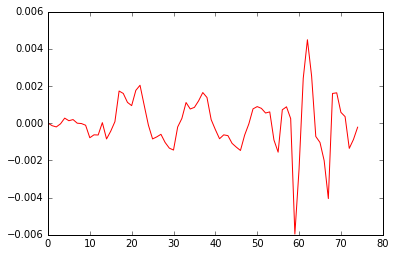

In [11]:
plt.plot(orbit0,'r-')

## Control machine with certain model-based approach, e.g. correct orbit

### First introduce a kick on the first horizontal corrector (h-corrector)

In [12]:
hcor0 = mp.get_elements(type='HCOR')[0]

In [13]:
print(hcor0.name)

LS1_CA01:DCH_D1131


### Check the present settings of the first h-corrector, see the above beam trajectory figure

In [14]:
lat.get(hcor0, source='model')

{u'ANG': 0.0}

In [15]:
lat.get(hcor0, source='control')

{u'ANG': 0.0}

### Apply a certain level kick strength, e.g. let kick angle be 1.0 mrad

In [16]:
lat.set(hcor0, value=0.001, field='ANG')
time.sleep(10)

In [17]:
lat.set?

### Check the settings after the setting action

In [18]:
print(lat.get(hcor0))
print(lat.get(hcor0, source='control'))
print(lat.get(hcor0, source='model'))

{u'ANG': 0.001000153312251364}
{u'ANG': 0.001000153312251364}
{u'ANG': 0.001}


In [19]:
print(lat.trace_history())

2017-02-03 13:48:41 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     0.000000e+00


### Check BPM readings again

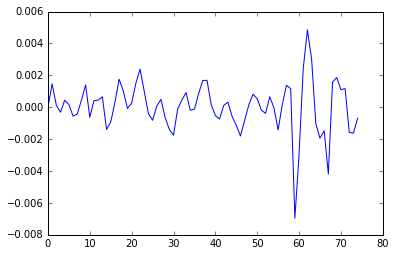

In [20]:
orbit1 = get_readback(pv_bpm_x)
plt.plot(orbit1, 'b-')

### roll_back feature

In [21]:
lat.roll_back()

In [22]:
print(lat.trace_history())

2017-02-03 13:48:41 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:52 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     0.000000e+00 which was     1.000000e-03
2017-02-03 13:48:41 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:52 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     0.000000e+00 which was     1.000000e-03


### Check BPM after rolling set back

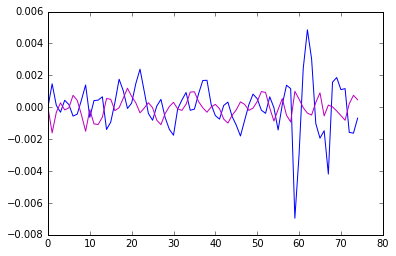

In [23]:
orbit2 = get_readback(pv_bpm_x)
plt.plot(orbit2, 'b-')
plt.plot(np.array(orbit0)-np.array(orbit1), 'm')

### Apply model-based orbit correction approach
<img src="tunningflow.png" title="model-based", width=700, align=left>

### Re-apply kicker

In [24]:
lat.set(hcor0, value=0.001, field='ANG')
time.sleep(10)

### Generate lattice file for modeling code

In [25]:
latfile1 = lat.run()

In [26]:
print(latfile1)

/home/tong/phantasy_data/20170203/model_data/data_6Hf_5n/model_cdtJ9P.lat


Now users has the highest privilege to do anything to the lattice, this is the portal for interfacing any kind of  physics procedures that take lattice file as input, and likewise export final lattice file as feedback, ``phantasy`` has libraries/utilities to make information transfer smoothly between the two environment.

### Demonstrate to use ``flameutils``

In [27]:
from phantasy import flameutils
from flame import Machine

In [28]:
m = Machine(open(latfile1, 'r'))
ms = flameutils.MachineStates(machine=m)
fm = flameutils.ModelFlame()
fm.mstates, fm.machine = ms, m
obs = fm.get_index_by_type(type='bpm')['bpm']
r,s = fm.run(monitor=obs)
data = fm.collect_data(r, pos=True, x0_env=True)

In [29]:
flameutils.generate_latfile?

### See documentation of ``genopt`` and ``phantasy`` for further information of how to make the full usage, at:
https://controls.frib.msu.edu/genopt and https://controls.frib.msu.edu/phantasy

``phantasy`` has a convenient tool to correct orbit, named as ``correct_orbit``, that way, the corrected lattice file is ready as latfile2.

In [30]:
latfile2 = 'model_oc.lat'

In [31]:
lat.sync_settings?

In [32]:
#### Update settings to model

In [33]:
lat.update_model_settings(latfile2)

In [34]:
#### Synchronize settings from model to control

In [35]:
lat.sync_settings(data_source='model') 

### Check setting action log:

In [36]:
print(lat.trace_history(), file=open('log.dat', 'w'))

2017-02-03 13:48:41 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:41 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:52 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     0.000000e+00 which was     1.000000e-03
2017-02-03 13:48:52 [control] set VA:LS1_CA01:DCH_D1131:ANG_CSET     with     1.000000e-03 which was     0.000000e+00
2017-02-03 13:48:52 [ model ] set LS1_CA01:DCH_D1131:ANG             with     1.000000e-03 which was     1.000000e-03
2017-02-03 13:49:02 [ model ] set LS1_CA01:CAV1_D1127:PHA            with     3.250260e+02 which was    -3.500000e+01
2017-02-03 13:49:02 [ model ] set LS1_CA01:CAV1_D1127:AMP            with     6.405610e-01 which was     6.400000e-01
2017-02-03 13:49:02 [ model ] set LS1_CA01:CAV1_D1127:FREQ           with     8.050000e+07 which was     8.050000e+07
2017-02-03 13:49:02 [ model ] set LS1_CA01:SOL1_D1131:B 

### Check BPM after tunning

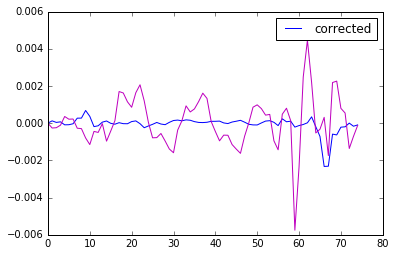

In [37]:
orbit3 = get_readback(pv_bpm_x)
plt.plot(orbit3, 'b-',label='corrected')
plt.plot(np.array(orbit0)-np.array(orbit3), 'm')
plt.legend()